In [ ]:
!nvidia-smi

Sat Apr 15 00:39:00 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8    11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install ultralytics
!pip install supervision

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 513.5/513.5 kB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 kB 24.6 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.0.78 🚀 Python-3.9.16 torch-2.0.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 23.2/166.8 GB disk)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls '/content/drive/MyDrive/Datasets/Animals'
!ls '/content/drive/MyDrive/Datasets/Animals/train/'

data.yaml	    README.roboflow.txt  testing.mp4  valid
README.dataset.txt  test		 train
images	labels	labels.cache


In [ ]:
SOURCE_VIDEO_PATH = "/content/drive/MyDrive/Datasets/Animals/testing.mp4"
TARGET_VIDEO_PATH = "/content/drive/MyDrive/Datasets/Animals/output.mp4"

In [ ]:
import os
HOME = os.getcwd()
%cd {HOME}
!git clone https://github.com/ifzhang/ByteTrack.git
%cd {HOME}/ByteTrack

# workaround related to https://github.com/roboflow/notebooks/issues/80
!sed -i 's/onnx==1.8.1/onnx==1.9.0/g' requirements.txt

!pip3 install -q -r requirements.txt
!python3 setup.py -q develop
!pip install -q cython_bbox
!pip install -q onemetric

from IPython import display
display.clear_output()


import sys
sys.path.append(f"{HOME}/ByteTrack")


import yolox
print("yolox.__version__:", yolox.__version__)

yolox.__version__: 0.1.0


In [ ]:
from yolox.tracker.byte_tracker import BYTETracker, STrack
from onemetric.cv.utils.iou import box_iou_batch
from dataclasses import dataclass


@dataclass(frozen=True)
class BYTETrackerArgs:
    track_thresh: float = 0.25
    track_buffer: int = 30
    match_thresh: float = 0.8
    aspect_ratio_thresh: float = 3.0
    min_box_area: float = 1.0
    mot20: bool = False

In [ ]:
!pip install supervision==0.1.0


from IPython import display
display.clear_output()


import supervision
print("supervision.__version__:", supervision.__version__)

supervision.__version__: 0.1.0


In [ ]:
from supervision.draw.color import ColorPalette
from supervision.geometry.dataclasses import Point
from supervision.video.dataclasses import VideoInfo
from supervision.video.source import get_video_frames_generator
from supervision.video.sink import VideoSink
from supervision.notebook.utils import show_frame_in_notebook
from supervision.tools.detections import Detections, BoxAnnotator
from supervision.tools.line_counter import LineCounter, LineCounterAnnotator

In [ ]:
VideoInfo.from_video_path(SOURCE_VIDEO_PATH)

VideoInfo(width=640, height=360, fps=25, total_frames=2501)

In [ ]:
from typing import List

import numpy as np


# converts Detections into format that can be consumed by match_detections_with_tracks function
def detections2boxes(detections: Detections) -> np.ndarray:
    return np.hstack((
        detections.xyxy,
        detections.confidence[:, np.newaxis]
    ))


# converts List[STrack] into format that can be consumed by match_detections_with_tracks function
def tracks2boxes(tracks: List[STrack]) -> np.ndarray:
    return np.array([
        track.tlbr
        for track
        in tracks
    ], dtype=float)


# matches our bounding boxes with predictions
def match_detections_with_tracks(
    detections: Detections, 
    tracks: List[STrack]
) -> Detections:
    if not np.any(detections.xyxy) or len(tracks) == 0:
        return np.empty((0,))

    tracks_boxes = tracks2boxes(tracks=tracks)
    iou = box_iou_batch(tracks_boxes, detections.xyxy)
    track2detection = np.argmax(iou, axis=1)
    
    tracker_ids = [None] * len(detections)
    
    for tracker_index, detection_index in enumerate(track2detection):
        if iou[tracker_index, detection_index] != 0:
            tracker_ids[detection_index] = tracks[tracker_index].track_id

    return tracker_ids

In [ ]:
from ultralytics import YOLO

# Load a model
model = YOLO("yolov8m.pt")  # load a pretrained model (recommended for training)

# Use the model
results = model.train(data="/content/drive/MyDrive/Datasets/Animals/data.yaml", epochs=25, imgsz=640)  # train the model

100%|██████████| 49.7M/49.7M [00:00<00:00, 56.8MB/s]
Ultralytics YOLOv8.0.78 🚀 Python-3.9.16 torch-2.0.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
yolo/engine/trainer: task=detect, mode=train, model=yolov8m.pt, data=/content/drive/MyDrive/Datasets/Animals/data.yaml, epochs=25, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=None, exist_ok=False, pretrained=False, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls=False, image_weights=False, rect=False, cos_lr=False, close_mosaic=0, resume=False, amp=True, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, line_thickness=3, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, f

In [ ]:
results = model.val()

Ultralytics YOLOv8.0.78 🚀 Python-3.9.16 torch-2.0.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 218 layers, 25843234 parameters, 0 gradients, 78.7 GFLOPs
val: Scanning /content/drive/MyDrive/Datasets/Animals/valid/labels.cache... 333 images, 0 backgrounds, 0 corrupt: 100%|██████████| 333/333 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:13<00:00,  1.54it/s]
                   all        333        406      0.958      0.879      0.948      0.775
               Cheetah        333         93      0.958      0.914      0.942      0.757
                   Fox        333         50      0.952       0.84       0.91       0.73
                 Hyena        333         74      0.946      0.851      0.944      0.784
                  Lion        333         55       0.96      0.909      0.986      0.826
                 Tiger        333         62      0.947      0.903      0.962      0.752
     

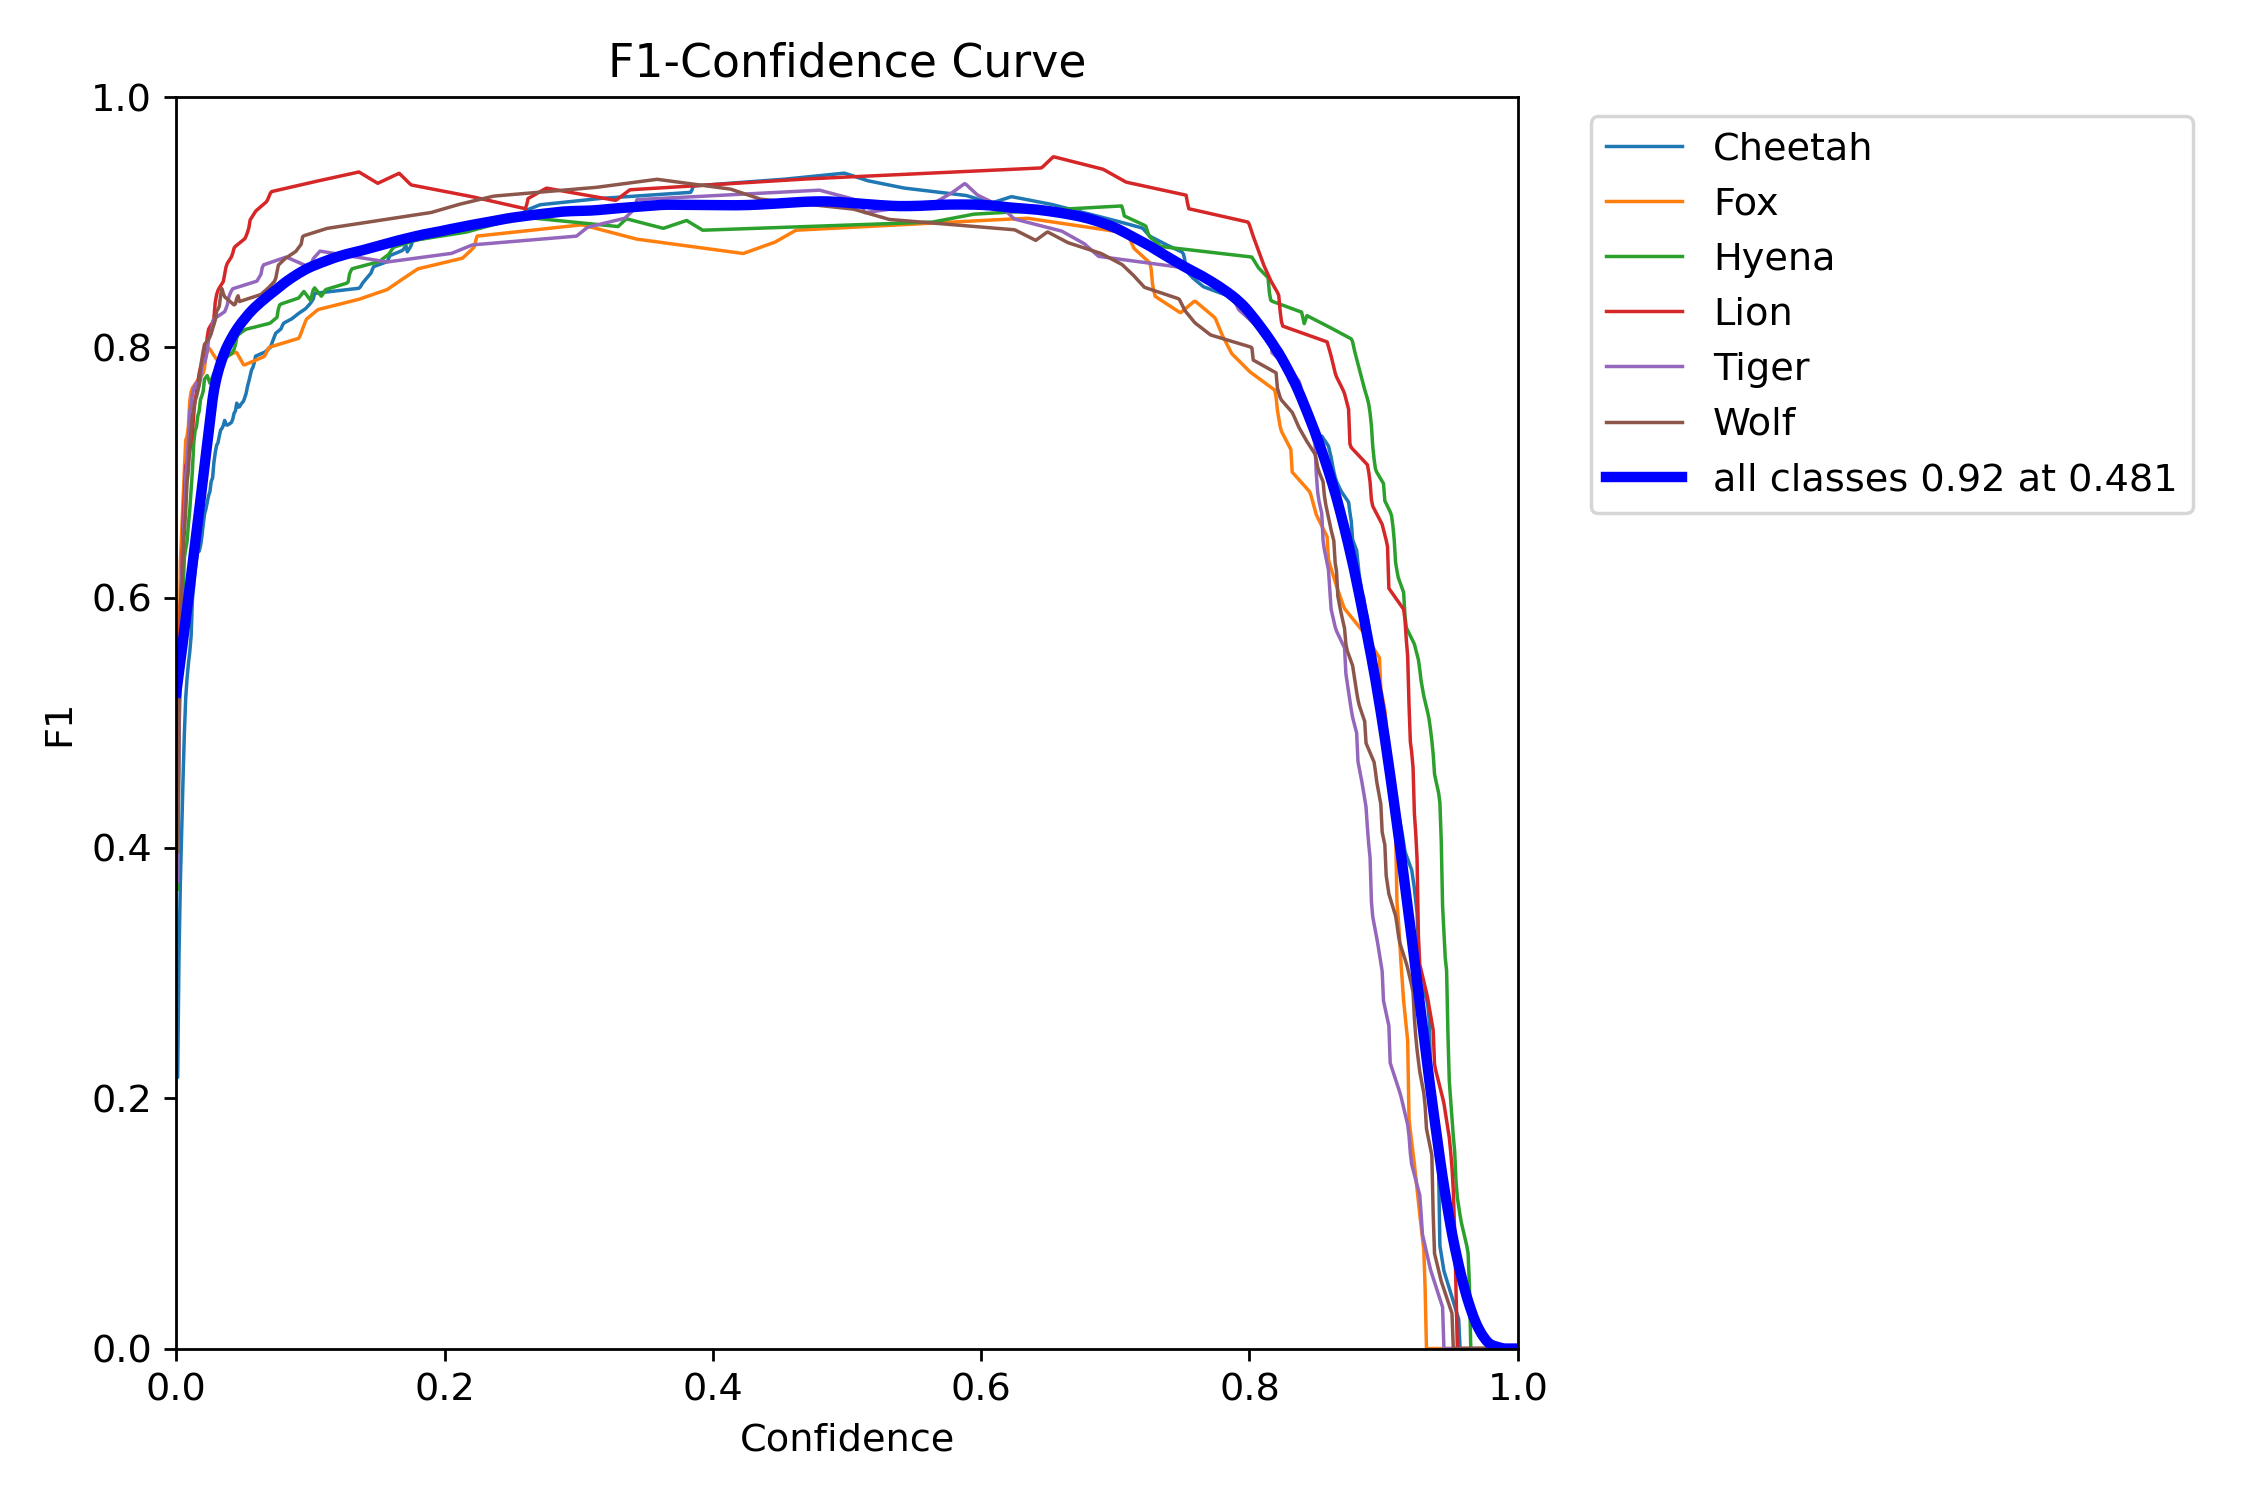

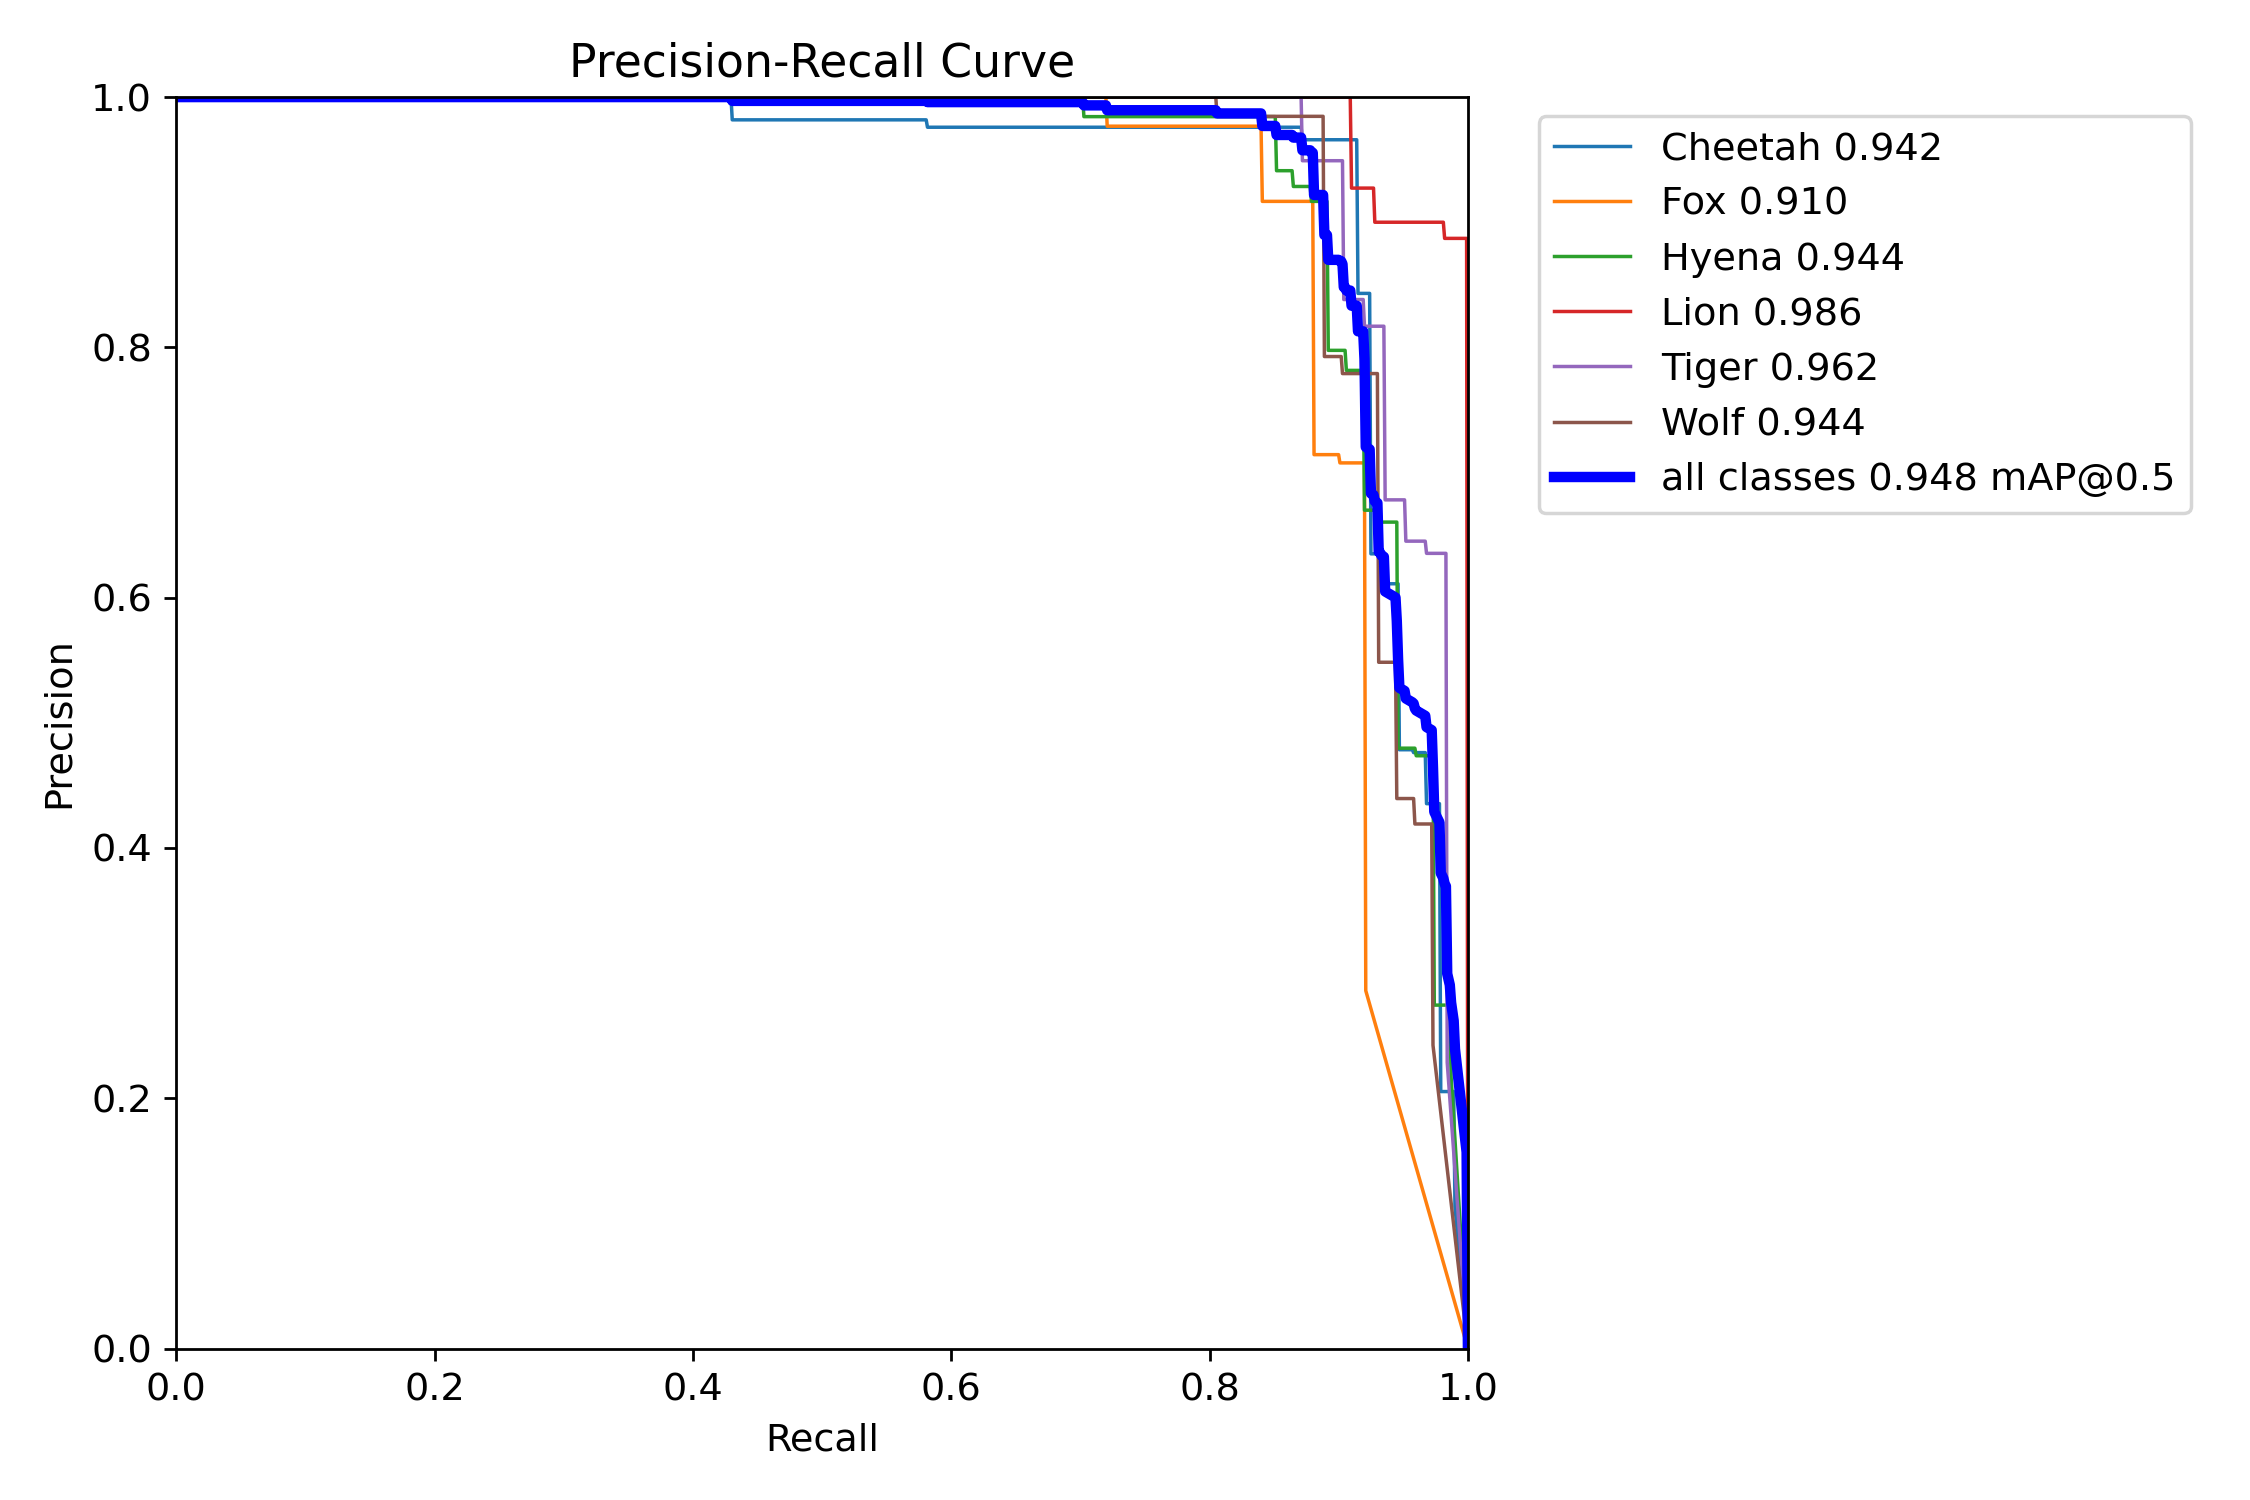

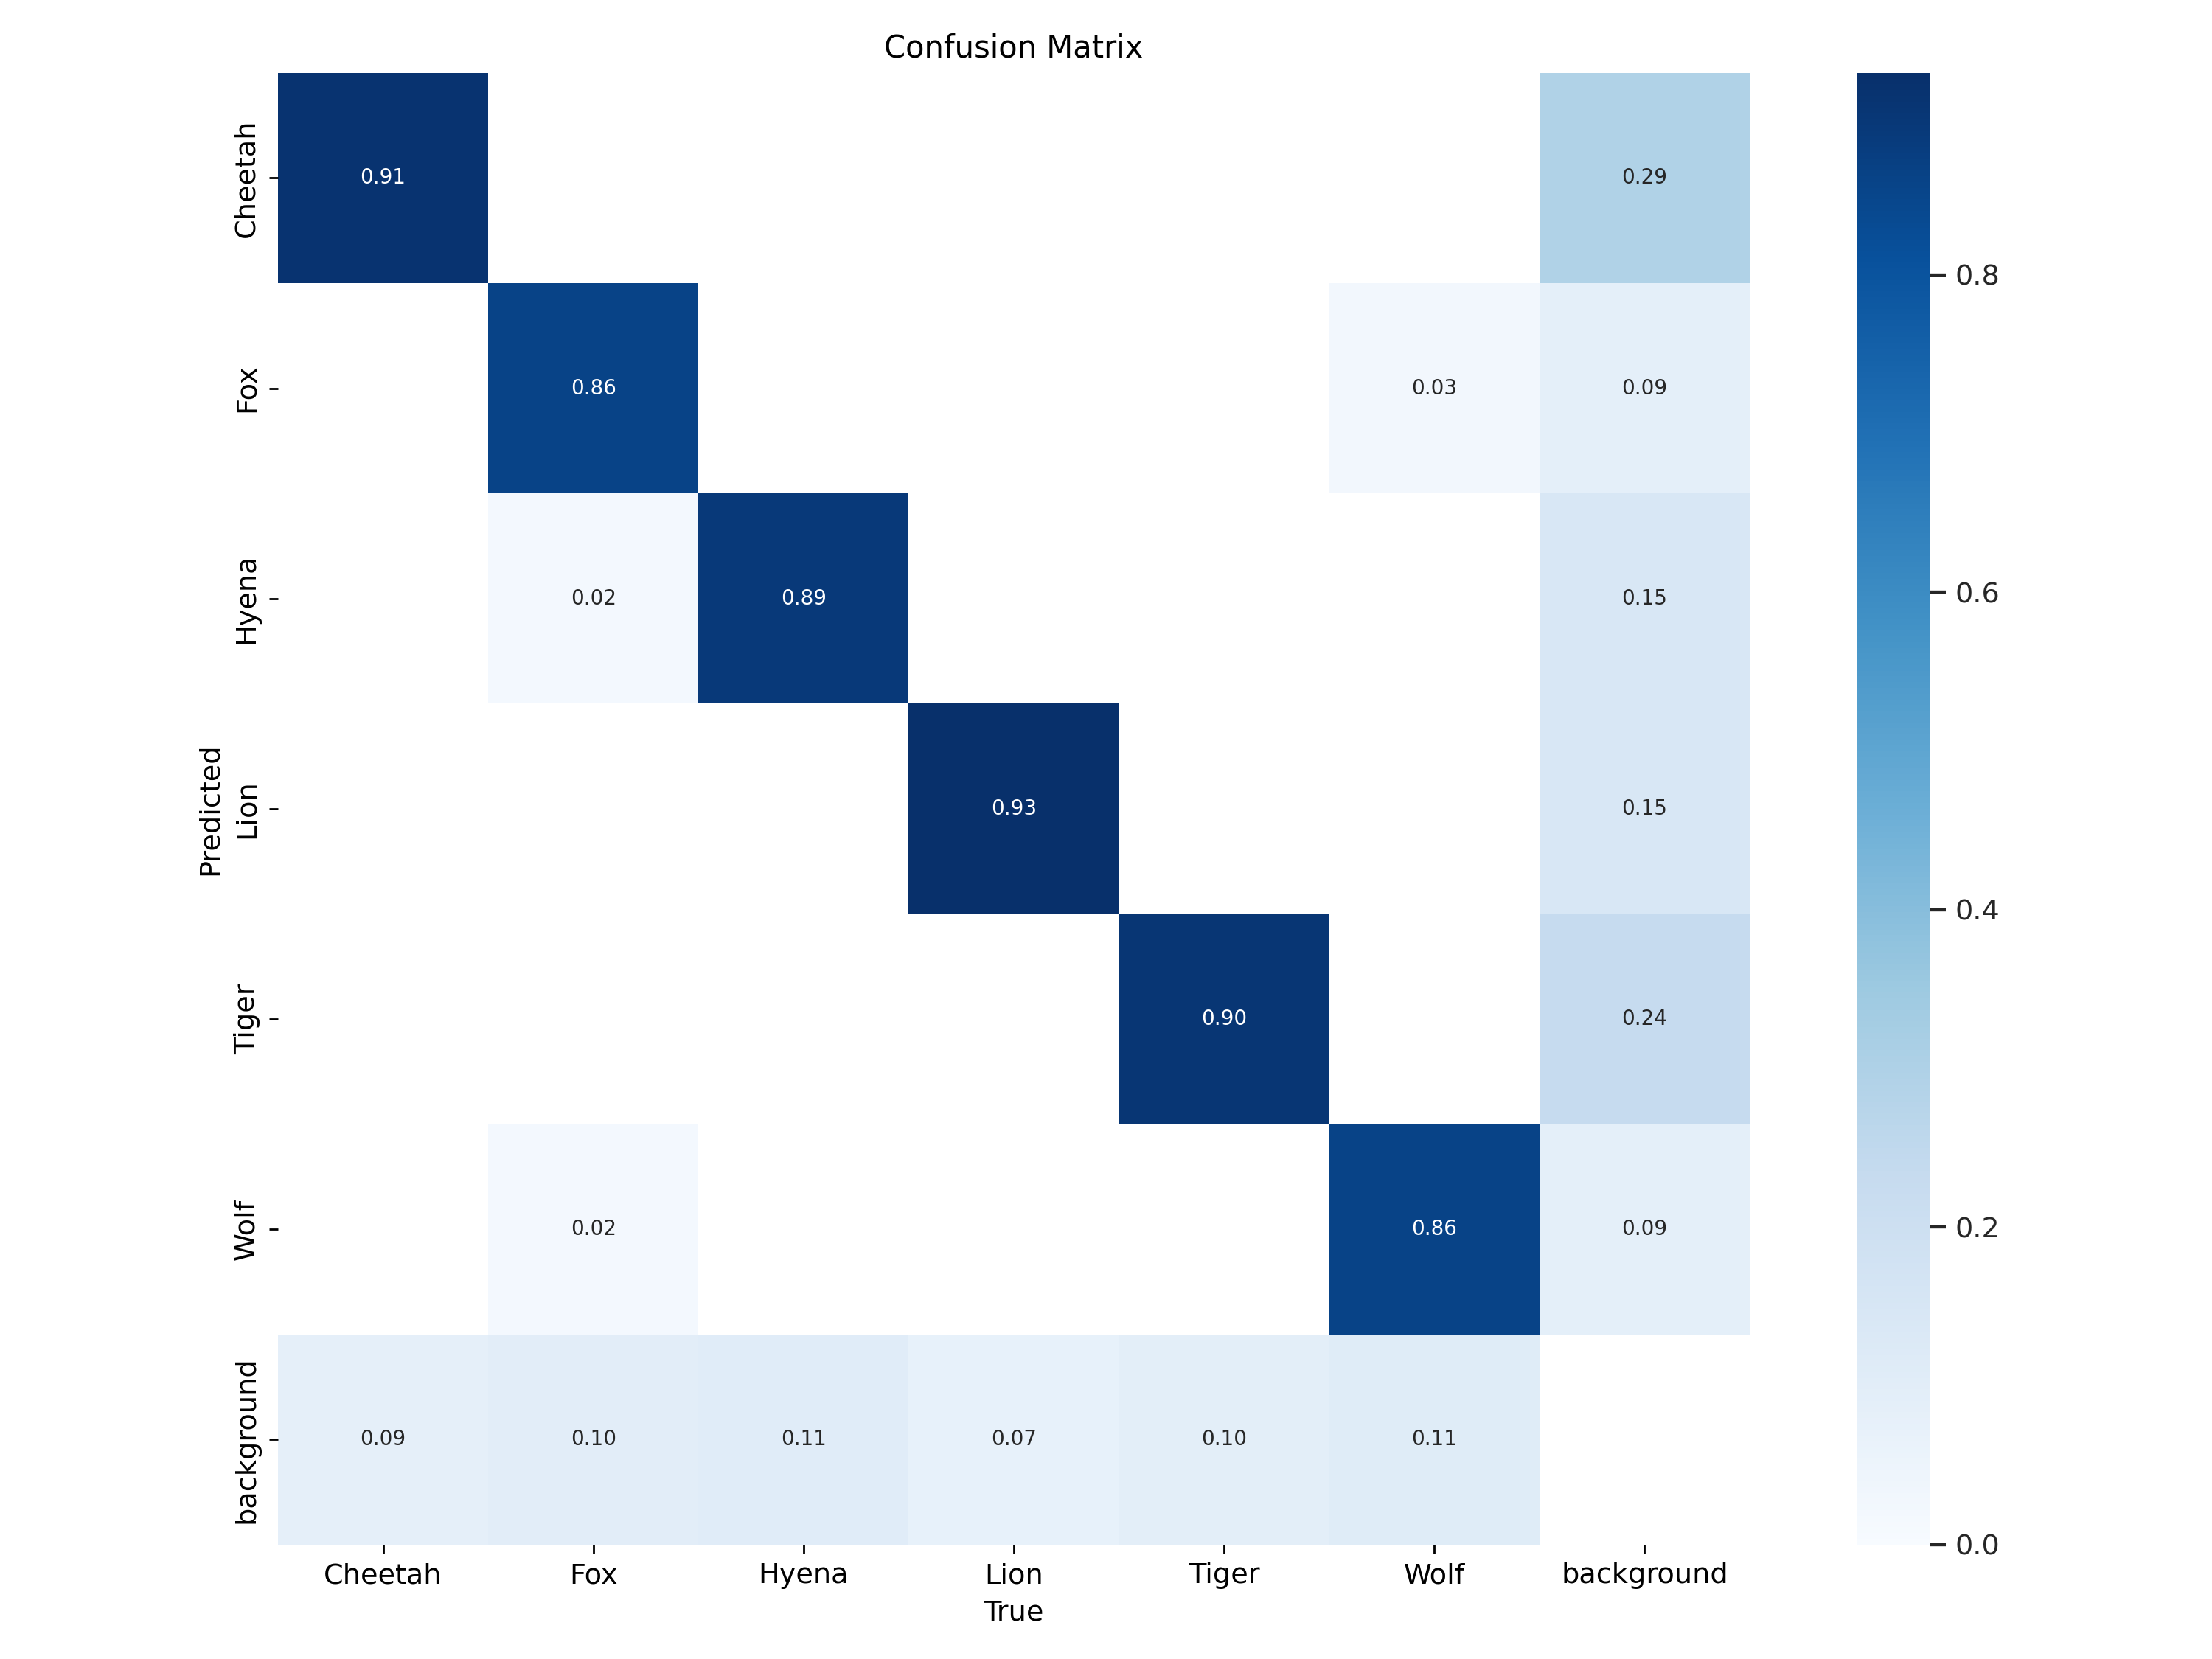

In [ ]:
# dislaying metrics for train data
from IPython.display import Image
from IPython.display import display
x = Image(filename='runs/detect/train/F1_curve.png') 
y = Image(filename='runs/detect/train/PR_curve.png') 
z = Image(filename='runs/detect/train/confusion_matrix.png') 
display(x, y,z)

In [ ]:
model = YOLO("runs/detect/train/weights/best.pt")  # load a custom mode

In [ ]:
CLASS_NAMES_DICT = model.model.names
CLASS_ID = [1, 2, 3, 4, 5, 6]

In [ ]:
from tqdm.notebook import tqdm

# create BYTETracker instance
byte_tracker = BYTETracker(BYTETrackerArgs())
# create VideoInfo instance
video_info = VideoInfo.from_video_path(SOURCE_VIDEO_PATH)
# create frame generator
generator = get_video_frames_generator(SOURCE_VIDEO_PATH)
# create LineCounter instance
# create instance of BoxAnnotator and LineCounterAnnotator
box_annotator = BoxAnnotator(color=ColorPalette(), thickness=4, text_thickness=4, text_scale=2)

# open target video file
with VideoSink(TARGET_VIDEO_PATH, video_info) as sink:
    # loop over video frames
    for frame in tqdm(generator, total=video_info.total_frames):
        # model prediction on single frame and conversion to supervision Detections
        results = model(frame)
        detections = Detections(
            xyxy=results[0].boxes.xyxy.cpu().numpy(),
            confidence=results[0].boxes.conf.cpu().numpy(),
            class_id=results[0].boxes.cls.cpu().numpy().astype(int)
        )
        # filtering out detections with unwanted classes
        mask = np.array([class_id in CLASS_ID for class_id in detections.class_id], dtype=bool)
        detections.filter(mask=mask, inplace=True)
        # tracking detections
        tracks = byte_tracker.update(
            output_results=detections2boxes(detections=detections),
            img_info=frame.shape,
            img_size=frame.shape
        )
        tracker_id = match_detections_with_tracks(detections=detections, tracks=tracks)
        detections.tracker_id = np.array(tracker_id)
        # filtering out detections without trackers
        mask = np.array([tracker_id is not None for tracker_id in detections.tracker_id], dtype=bool)
        detections.filter(mask=mask, inplace=True)
        # format custom labels
        labels = [
            f"#{tracker_id} {CLASS_NAMES_DICT[class_id]} {confidence:0.2f}"
            for _, confidence, class_id, tracker_id
            in detections
        ]
        # annotate and display frame
        frame = box_annotator.annotate(frame=frame, detections=detections, labels=labels)
        
        sink.write_frame(frame)

  0%|          | 0/2501 [00:00<?, ?it/s]

Streaming output truncated to the last 5000 lines.
0: 384x640 (no detections), 13.0ms
Speed: 0.5ms preprocess, 13.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 13.3ms
Speed: 0.5ms preprocess, 13.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 (no detections), 13.2ms
Speed: 0.4ms preprocess, 13.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 Lion, 11.9ms
Speed: 0.5ms preprocess, 11.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 Lion, 11.8ms
Speed: 0.8ms preprocess, 11.8ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 Lion, 14.1ms
Speed: 0.5ms preprocess, 14.1ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 Lion, 12.1ms
Speed: 0.4ms preprocess, 12.1ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 1 Lion, 11.8ms
Speed: 0.4ms preprocess, 11.